In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import tsai.all as ts
import torch
from torch import nn
from my_utilities import time_frequency_analysis, mma_Partition, time_frequency_analysis_output_1s
from sklearn.linear_model import RidgeClassifierCV

import time

In [10]:
# 对同样的数据，不同的H值进行测试

srate = 2000
new_srate = 200
sec = 3  # time step length
ele = pd.read_csv('data/ele_4_60_hz.csv', header = None, index_col = None).to_numpy()
# shape = (4, 15, 2, 20000, 14)
# 去除第一秒的数据,且重采样到200hz
ele = np.reshape(
    ele, (20000,15,4,2,14), order = 'F').transpose([2,1,3,0,4])[:,:,:,srate::srate//new_srate,:]



# z-score
ear_ele = ele[...,:8].astype(np.float32).reshape(-1,int(200 * sec),8).transpose([0,2,1])
ear_ele = (ear_ele - ear_ele.mean(axis = 2)[...,np.newaxis])\
                /ear_ele.std(axis = 2)[...,np.newaxis]


tfa_for_different_H = []
for H in [0.25, 0.5, 0.75, 1]:
    temp_ear_ele = []
    for i in ear_ele:
        _,_,temp = time_frequency_analysis(
            i.T, srate = new_srate, max_freq = 60, min_freq = 2, num_freq = 59, fwhm = sec * H)   
        temp_ear_ele.append(temp)
    tfa_for_different_H.append(temp_ear_ele)
    
H_0D3, H_0D6, H_0D9, H1D2 = tuple(np.asarray(tfa_for_different_H))
y = np.repeat([0,1,2,3], int(H_0D3.shape[0]/4))

In [3]:
H_0D3.shape, y.shape

((480, 59, 400), (480,))

In [11]:
def cross_validation(x0, x1, x2, x3, y, cv_number = 20, test_size = 0.1):
    '''
    args:
        multi: 如果x是输入的集合，即(不同H, sample, channel, time)
    '''
    acc = []
    batch_tfms = [ts.TSStandardize(by_sample=True)]
    tfms  = [None, [ts.Categorize()]]

    
    for _ in np.arange(cv_number):
        HH_0D3, HH_0D6, HH_0D9, HH_1D2, ear_y = shuffle(x0, x1, x2, x3, y)
        splits  =ts.get_splits(ear_y, valid_size= test_size, stratify=True, shuffle=True)
        
        dls_0D3 = ts.get_ts_dls(HH_0D3, ear_y, 
                         splits=splits, 
                         tfms=tfms, drop_last=False, 
                         shuffle_train=False, batch_tfms=batch_tfms, bs=10_000)
        
        dls_0D6 = ts.get_ts_dls(HH_0D6, ear_y, 
                         splits=splits, 
                         tfms=tfms, drop_last=False, 
                         shuffle_train=False, batch_tfms=batch_tfms, bs=10_000)

        dls_0D9 = ts.get_ts_dls(HH_0D9, ear_y, 
                         splits=splits, 
                         tfms=tfms, drop_last=False, 
                         shuffle_train=False, batch_tfms=batch_tfms, bs=10_000)
        
        dls_1D2 = ts.get_ts_dls(HH_1D2, ear_y, 
                         splits=splits, 
                         tfms=tfms, drop_last=False, 
                         shuffle_train=False, batch_tfms=batch_tfms, bs=10_000)
        
        temp_acc = []
        for dls in [dls_0D3, dls_0D6, dls_0D9, dls_1D2]:
            model = ts.build_ts_model(ts.ROCKET, dls=dls)

            X_train, y_train = ts.create_rocket_features(dls.train, model)
            X_valid, y_valid = ts.create_rocket_features(dls.valid, model)
            X_train.shape, X_valid.shape

            ridge = RidgeClassifierCV(alphas=np.logspace(-8, 8, 17), normalize=True)
            ridge.fit(X_train, y_train)
            # print(f'alpha: {ridge.alpha_:.2E}  train: {ridge.score(X_train, y_train):.5f}  valid: {ridge.score(X_valid, y_valid):.5f}')
            temp_acc.append(ridge.score(X_valid, y_valid))
        print(f'current accuracy: {temp_acc}.')
        acc.append(temp_acc)
    return acc

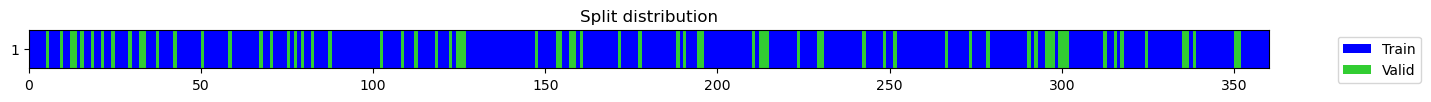

current accuracy: [0.625, 0.6666666666666666, 0.6527777777777778, 0.6805555555555556].


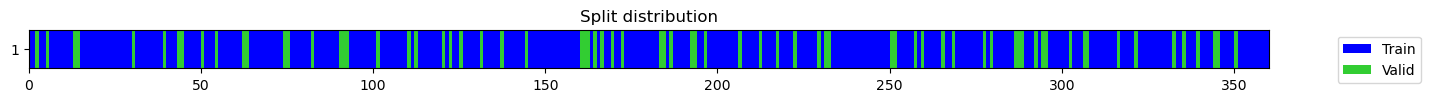

current accuracy: [0.5277777777777778, 0.6111111111111112, 0.6388888888888888, 0.5694444444444444].


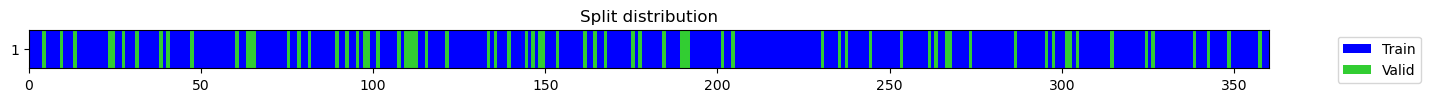

current accuracy: [0.7222222222222222, 0.7361111111111112, 0.7083333333333334, 0.75].


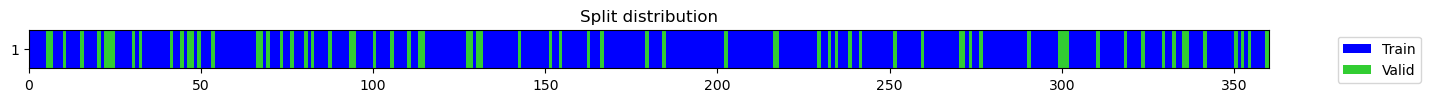

current accuracy: [0.6111111111111112, 0.7222222222222222, 0.75, 0.7361111111111112].


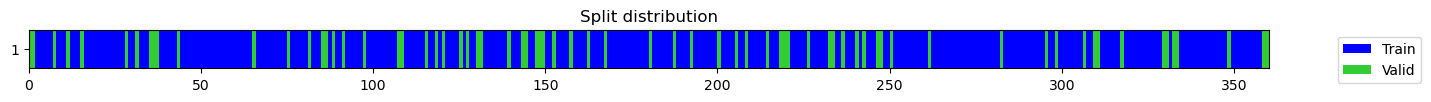

current accuracy: [0.625, 0.6666666666666666, 0.6666666666666666, 0.7083333333333334].


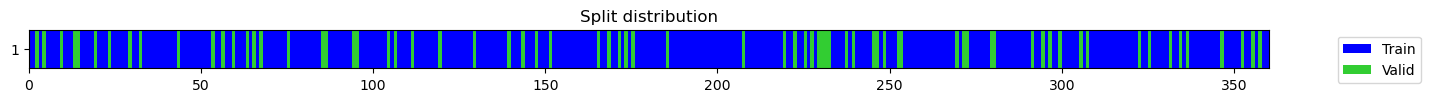

current accuracy: [0.5694444444444444, 0.7083333333333334, 0.7083333333333334, 0.6805555555555556].


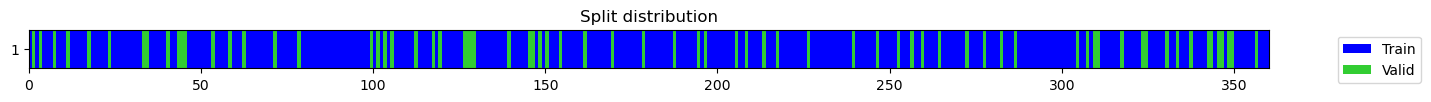

current accuracy: [0.6527777777777778, 0.7083333333333334, 0.7083333333333334, 0.6944444444444444].


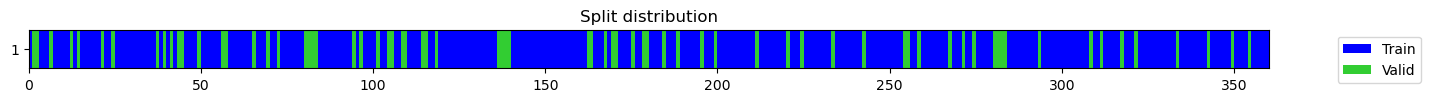

current accuracy: [0.6111111111111112, 0.5833333333333334, 0.5972222222222222, 0.5833333333333334].


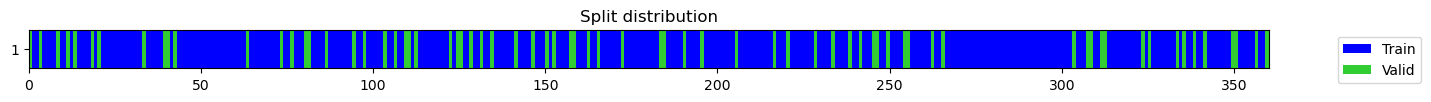

current accuracy: [0.6805555555555556, 0.7361111111111112, 0.7777777777777778, 0.7222222222222222].


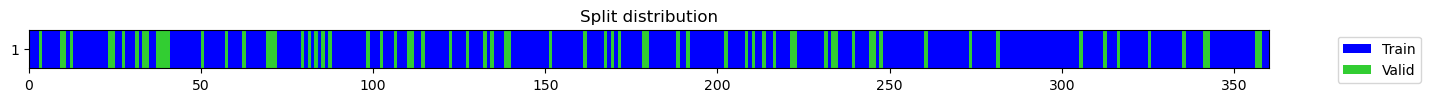

current accuracy: [0.6805555555555556, 0.7222222222222222, 0.7083333333333334, 0.7083333333333334].


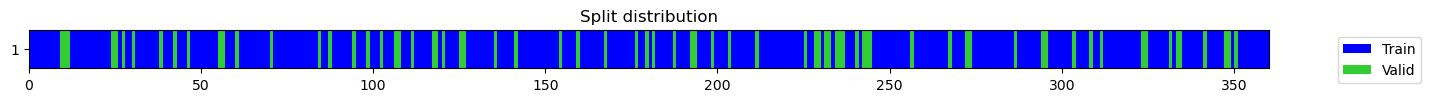

current accuracy: [0.6388888888888888, 0.6666666666666666, 0.6666666666666666, 0.6805555555555556].


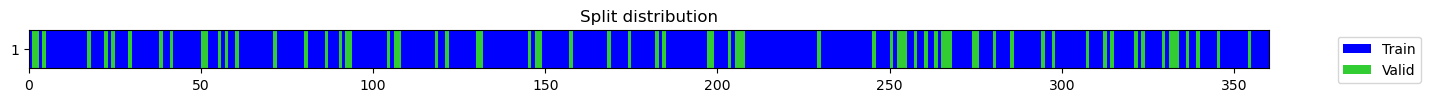

current accuracy: [0.5833333333333334, 0.5972222222222222, 0.625, 0.6111111111111112].


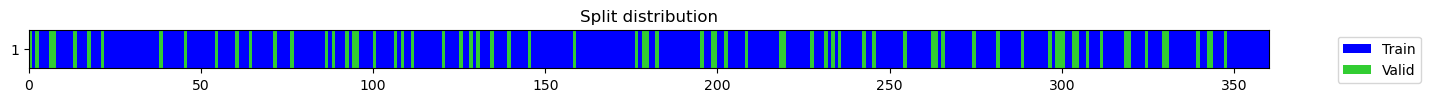

current accuracy: [0.6805555555555556, 0.6805555555555556, 0.7222222222222222, 0.7083333333333334].


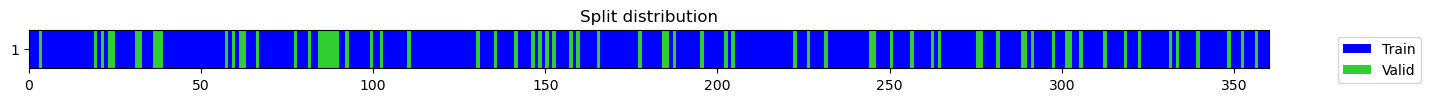

current accuracy: [0.6388888888888888, 0.6944444444444444, 0.6666666666666666, 0.6388888888888888].


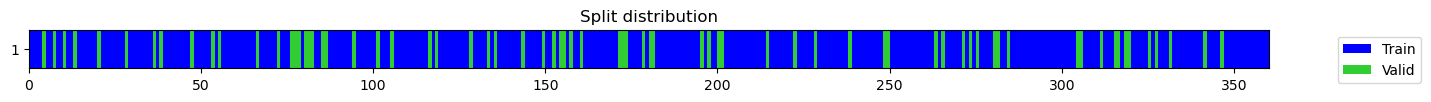

current accuracy: [0.5972222222222222, 0.6944444444444444, 0.6944444444444444, 0.7083333333333334].


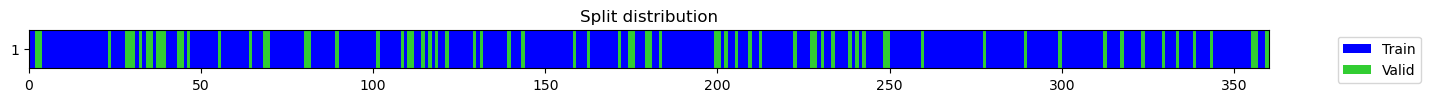

current accuracy: [0.625, 0.7361111111111112, 0.7777777777777778, 0.7638888888888888].


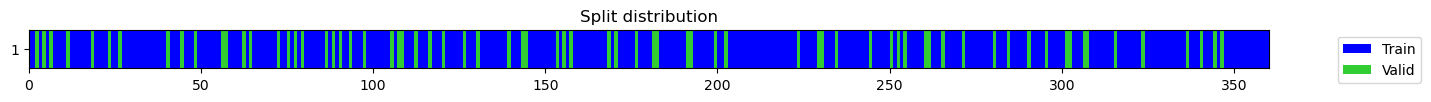

current accuracy: [0.6388888888888888, 0.6527777777777778, 0.6666666666666666, 0.6944444444444444].


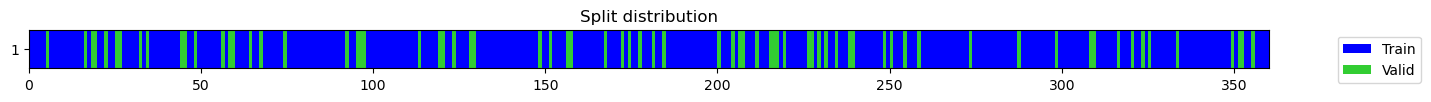

current accuracy: [0.625, 0.6944444444444444, 0.7083333333333334, 0.7222222222222222].


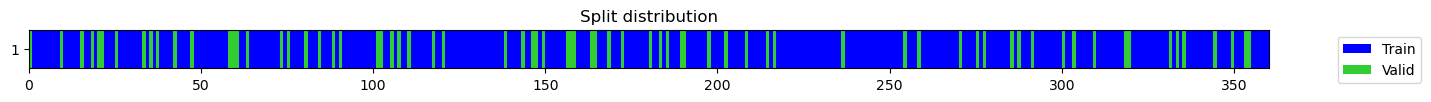

current accuracy: [0.6666666666666666, 0.6944444444444444, 0.6666666666666666, 0.6805555555555556].


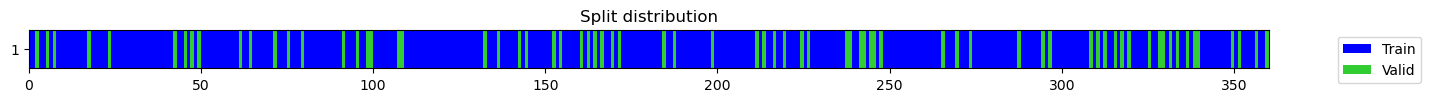

current accuracy: [0.6388888888888888, 0.6944444444444444, 0.6944444444444444, 0.7083333333333334].


In [12]:
h402 = cross_validation(H_0D3, H_0D6, H_0D9, H1D2, y, cv_number = 20, test_size = 0.2)

# pd.DataFrame(h402, 
#              columns = ['h=0.25', 'h=0.5', 'h=0.75', 'h=1']).to_csv(r'result\ROCKET_1S_4H.csv', index = 0)

In [13]:
np.asarray(h402).mean(axis = 0)

array([0.63194444, 0.68333333, 0.69027778, 0.6875    ])

In [52]:
pd.DataFrame(acc_4s_with_different_h, 
             columns = ['h=0.3', 'h=0.6', 'h=0.9', 'h=1.2']).to_csv(r'result\different_h_2s.csv', index = 0)

In [56]:
np.asarray(h402).mean(axis = 0)

array([0.69166667, 0.746875  , 0.753125  , 0.76354167])

In [14]:
pd.DataFrame(h402, 
             columns = [0.25, 0.5, 0.75, 1]).to_csv(r'result\different_h_3s.csv', index = 0)

<AxesSubplot: >

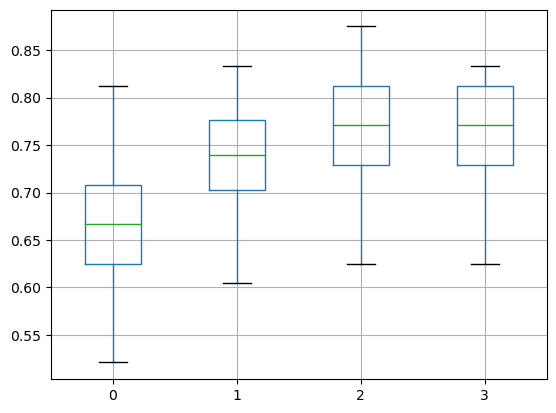

In [8]:
pd.DataFrame(h402).boxplot()